# 2D rotational average analysis of picked positions

In this notebook, we show how the picked positions can be analyzed using 2D rotational averages.
To this end, we 
1. extract 2D rotational averages for each picked position
2. create feature vectors for each rotational average using 3 different methods
3. perform clustering of these feature vectors using k-means to separate outlier averages
4. show that the predicted clusters agree very well with the manually selected outliers

In [1]:
%load_ext autoreload 
%autoreload 2
import os
import numpy as np

from surforama.io.star import load_points_layer_data_from_star_file
from surforama.io.mesh import read_obj_file

### Define data paths

In [2]:
example_usecase_dir = "../../example_usecase/"
star_files = [
    "M2.star",
    "M3b.star",
    "M3c.star",
    "M4b.star",
    "M5c.star"
]

mesh_files = [
    "Tomo1L1_M2.obj",
    "Tomo1L1_M3b.obj",
    "Tomo1L1_M3c.obj",
    "Tomo1L1_M4b.obj",
    "Tomo1L1_M5c.obj",
]

tomo_file = "Tomo1L1_bin4.rec"

star_files = [os.path.join(example_usecase_dir, f) for f in star_files]
mesh_files = [os.path.join(example_usecase_dir, f) for f in mesh_files]
tomo_file = os.path.join(example_usecase_dir, tomo_file)

### Load data and generate 2D rotational averages

In [3]:
from surforama.utils.twoD_averages import create_2D_averages
import trimesh
import mrcfile

def load_tomo(file_path):
    with mrcfile.open(file_path, permissive=True) as mrc:
        return mrc.data

tomo = load_tomo(tomo_file)
all_avgs = []
for star_file, mesh_file in zip(star_files, mesh_files):
    print(f"Computing averages for {star_file} and {mesh_file}.")
    
    # Load data
    point_coordinates, feature_table = load_points_layer_data_from_star_file(star_file)
    verts, faces, _ = read_obj_file(mesh_file)

    mesh = trimesh.Trimesh(vertices=verts, faces=faces)

    avgs = []
    avgs = create_2D_averages(
        positions=point_coordinates,
        mesh=mesh,
        tomogram=tomo,
        mirror=True
    )
    all_avgs.append(avgs)
all_avgs = np.concatenate(all_avgs, axis=0)

Computing averages for ../../example_usecase/M2.star and ../../example_usecase/Tomo1L1_M2.obj.
Computing averages for ../../example_usecase/M3b.star and ../../example_usecase/Tomo1L1_M3b.obj.
Computing averages for ../../example_usecase/M3c.star and ../../example_usecase/Tomo1L1_M3c.obj.
Computing averages for ../../example_usecase/M4b.star and ../../example_usecase/Tomo1L1_M4b.obj.
Computing averages for ../../example_usecase/M5c.star and ../../example_usecase/Tomo1L1_M5c.obj.


### Visualize generated rotational averages

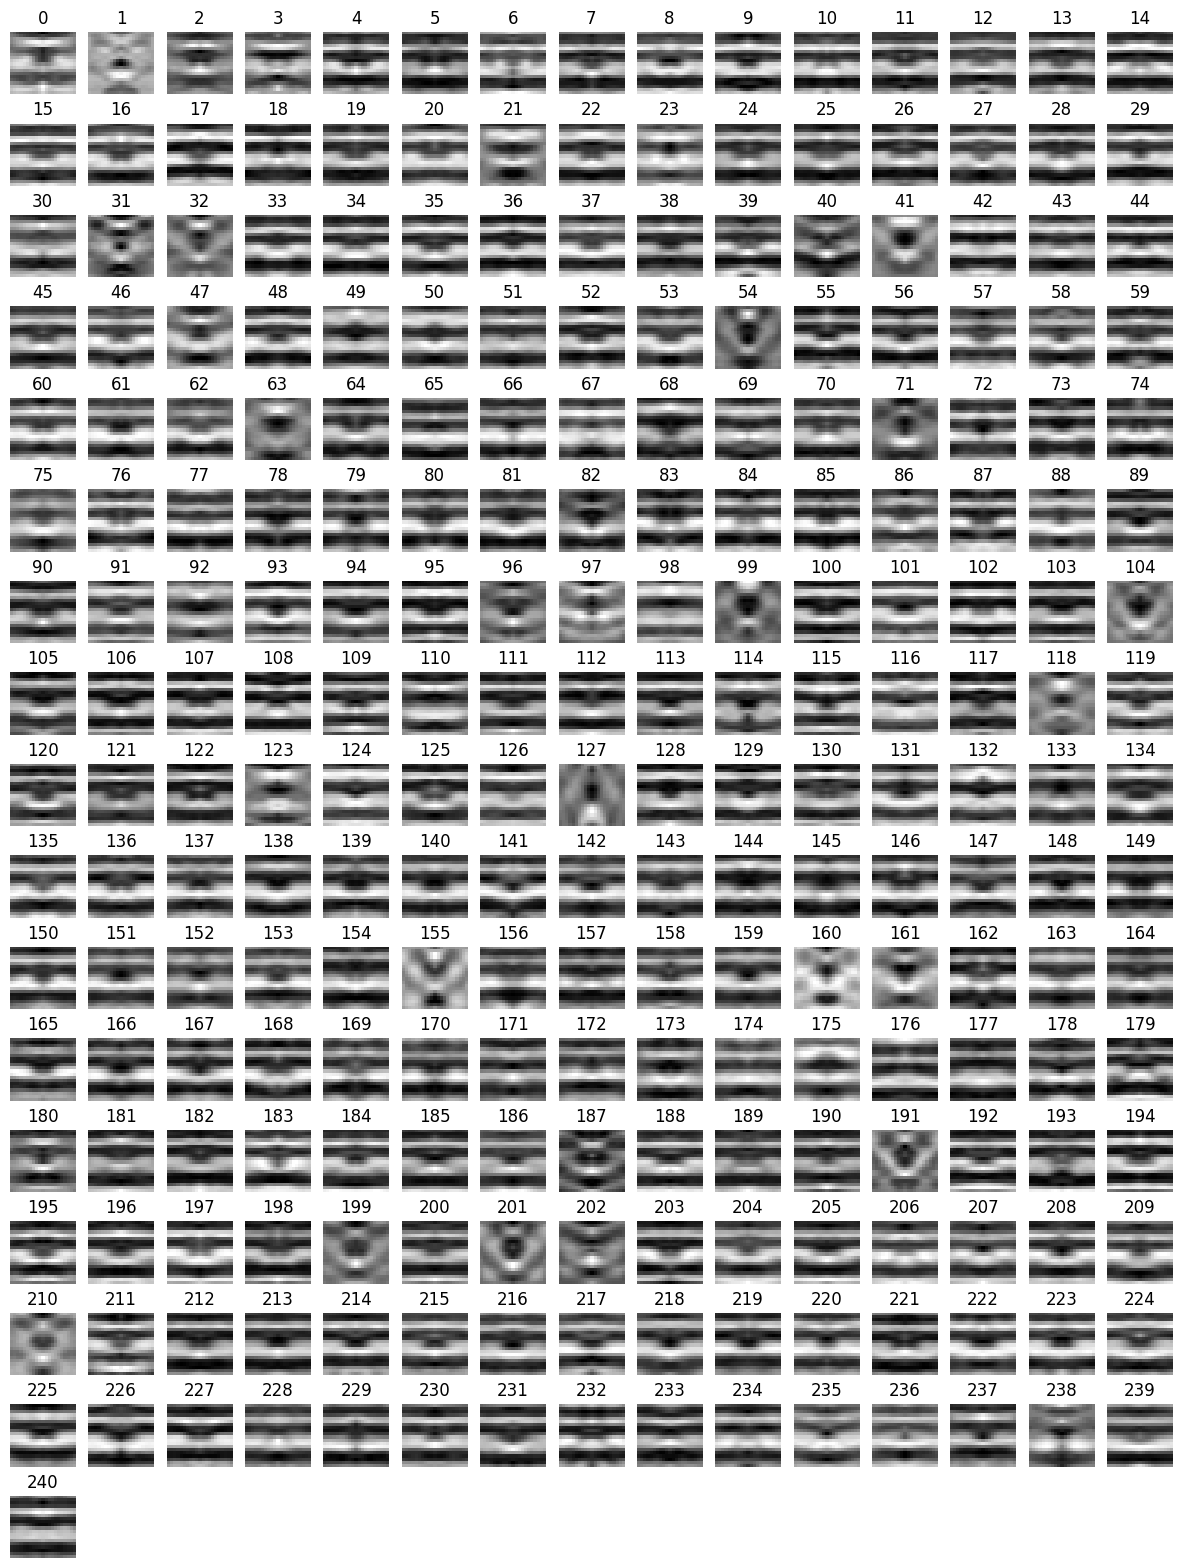

In [6]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15, 20))
num_cols = 15
num_rows = all_avgs.shape[0] // num_cols + 1
for i, avg in enumerate(all_avgs):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(avg, cmap="gray")
    plt.title(i)
    plt.axis("off")
plt.show()

### Select outlier averages

These outliers may be due to bad normal vectors, but also wrongly picked positions.
Here, we manually select them to show that they also cluster differently with several feature extractors.

In [7]:
mask_idcs = [1, 21, 31, 32, 40, 41, 47, 54, 
             63, 71, 82, 96, 97, 99, 104, 118, 
             123, 127, 155, 160, 161, 187, 
             199, 191, 201, 202, 210, 238] # These are based on visual inspection of above averages
outlier_mask = np.isin(np.arange(all_avgs.shape[0]), mask_idcs)


Visualize selected outliers:

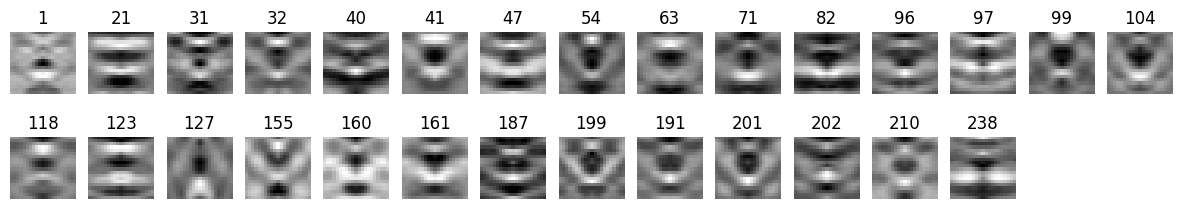

In [11]:
num_cols = 15
num_rows = outlier_mask.sum() // num_cols + 1
plt.figure(figsize=(15,2.5))
for i, avg in enumerate(all_avgs[outlier_mask]):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(avg, cmap="gray")
    plt.title(mask_idcs[i])
    plt.axis("off")

## Clustering

Here, we define different feature extractors that extract per-average features, which can be used to cluster our averages, particularly remove our outliers.

Different feature extractors:
- ResNet50 (pretrained on ImageNet)
- VGG16 (pretrained on ImageNet)
- Hog Features

In [47]:
import torch
from torchvision import models, transforms
from torch.nn.functional import adaptive_avg_pool2d
from PIL import Image
from skimage.feature import hog


class ResNet50Extractor(torch.nn.Module):
    def __init__(self):
        super(ResNet50Extractor, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.eval()
        self.resnet.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.resnet.fc = torch.nn.Identity()
    
    def forward(self, x):
        return self.resnet(x)
    
    def preprocess(self, image):
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image = Image.fromarray(image)
        img_t = preprocess(image)
        img_t = img_t.unsqueeze(0)
        return img_t
    

class VGG16Extractor(torch.nn.Module):
    def __init__(self):
        super(VGG16Extractor, self).__init__()
        self.vgg = models.vgg16(pretrained=True)
        self.vgg.eval()
        self.vgg.features.eval()  # Only use the features part
        self.vgg.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.vgg.classifier = torch.nn.Identity()
    
    def forward(self, x):
        return adaptive_avg_pool2d(self.vgg.features(x), (1, 1)).view(x.size(0), -1)
    
    def preprocess(self, image):
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        image = Image.fromarray(image)
        img_t = preprocess(image)
        img_t = img_t.unsqueeze(0)
        return img_t
    

class HogExtractor(torch.nn.Module):
    def __init__(self):
        super(HogExtractor, self).__init__()
    
    def forward(self, x):
        return hog(x, orientations=16, pixels_per_cell=(20, 21),
                        cells_per_block=(1, 1), visualize=True, channel_axis=-1)[0]
    
    def preprocess(self, image):
        return np.expand_dims(image, axis=-1)

In [48]:
vgg_extractor = VGG16Extractor()
resnet_extractor = ResNet50Extractor()
hog_extractor = HogExtractor()

# Extract features
features_vgg = []
features_resnet = []
features_hog = []
for avg in all_avgs:
    features_vgg.append(np.squeeze(vgg_extractor(vgg_extractor.preprocess(avg)).detach().numpy()))
    features_resnet.append(np.squeeze(resnet_extractor(resnet_extractor.preprocess(avg)).detach().numpy()))
    features_hog.append(np.squeeze(hog_extractor(hog_extractor.preprocess(avg))))
features_vgg = np.array(features_vgg)
features_resnet = np.array(features_resnet)
features_hog = np.array(features_hog)


/Users/lorenz.lamm/PhD_projects/Napari/Surforama/venv_surforama_new/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lorenz.lamm/PhD_projects/Napari/Surforama/venv_surforama_new/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Users/lorenz.lamm/PhD_projects/Napari/Surforama/venv_surforama_new/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

In [49]:
print(f"VGG features shape: {features_vgg.shape}")
print(f"ResNet features shape: {features_resnet.shape}")
print(f"HOG features shape: {features_hog.shape}")

VGG features shape: (241, 512)
ResNet features shape: (241, 2048)
HOG features shape: (241, 16)


### Perform k-means clustering based on the extracted features.

In [60]:
# cluster with k-means
from sklearn.cluster import KMeans
kmeans_vgg = KMeans(n_clusters=2, random_state=0).fit(features_vgg)
kmeans_resnet = KMeans(n_clusters=2, random_state=0).fit(features_resnet)
kmeans_hog = KMeans(n_clusters=2, random_state=0).fit(features_hog)


### Visualize clusters

We use t-sne plots to visualize that the outliers form clusters separate from the remaining averages.

In [57]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results_vgg = tsne.fit_transform(features_vgg)
tsne_results_resnet = tsne.fit_transform(features_resnet)
tsne_results_hog = tsne.fit_transform(features_hog)

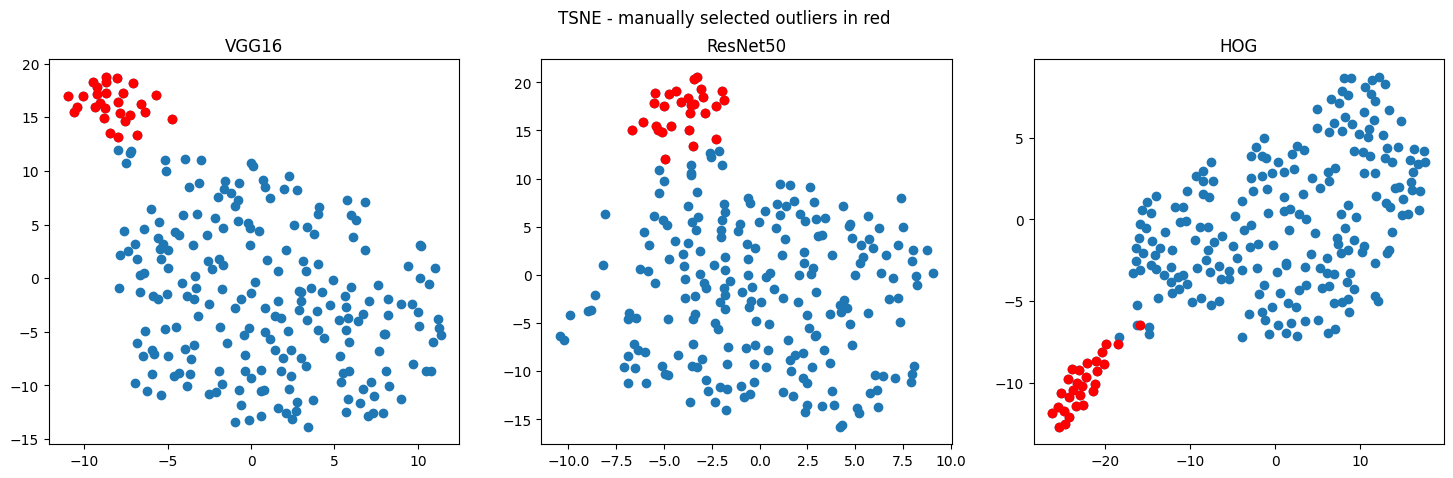

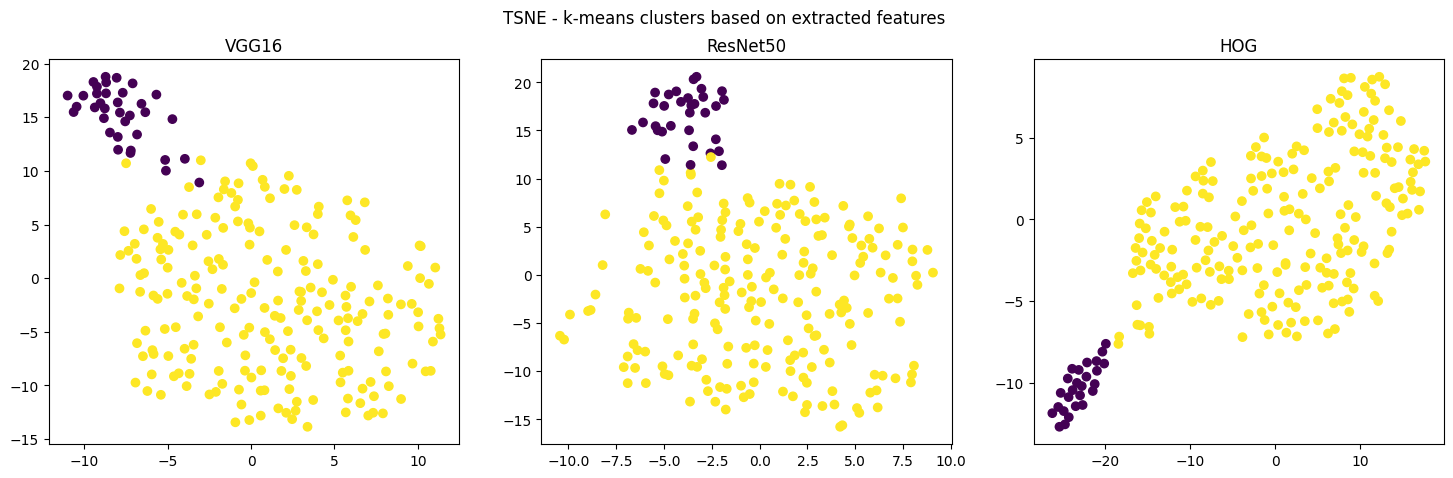

In [62]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18,5))
plt.suptitle("TSNE - manually selected outliers in red")
plt.subplot(131)
plt.scatter(tsne_results_vgg[:, 0], tsne_results_vgg[:, 1])
plt.scatter(tsne_results_vgg[outlier_mask, 0], tsne_results_vgg[outlier_mask, 1], c="red")
plt.title("VGG16")
plt.subplot(132)
plt.scatter(tsne_results_resnet[:, 0], tsne_results_resnet[:, 1])
plt.scatter(tsne_results_resnet[outlier_mask, 0], tsne_results_resnet[outlier_mask, 1], c="red")
plt.title("ResNet50")
plt.subplot(133)
plt.scatter(tsne_results_hog[:, 0], tsne_results_hog[:, 1])
plt.scatter(tsne_results_hog[outlier_mask, 0], tsne_results_hog[outlier_mask, 1], c="red")
plt.title("HOG")
plt.show()


# plot the clusters
plt.figure(figsize=(18,5))
plt.suptitle("TSNE - k-means clusters based on extracted features")
plt.subplot(131)
plt.scatter(tsne_results_vgg[:, 0], tsne_results_vgg[:, 1], c=kmeans_vgg.labels_)
plt.title("VGG16")
plt.subplot(132)
plt.scatter(tsne_results_resnet[:, 0], tsne_results_resnet[:, 1], c=kmeans_resnet.labels_)
plt.title("ResNet50")
plt.subplot(133)
plt.scatter(tsne_results_hog[:, 0], tsne_results_hog[:, 1], c=kmeans_hog.labels_)
plt.title("HOG")
plt.show()




### Show some example averages from predicted outliers and predicted non-outliers

Here, we only show exemplarily the outliers and non-outliers based on VGG-16 features.

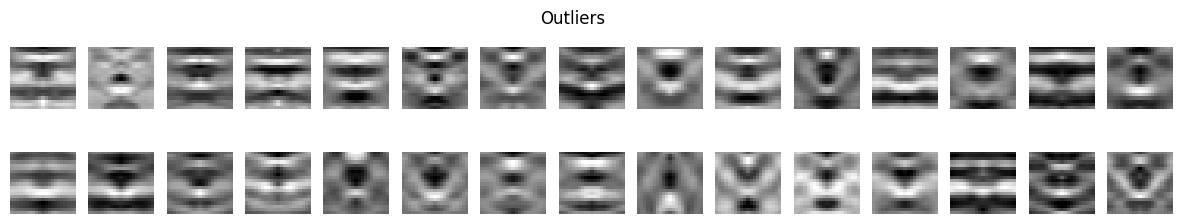

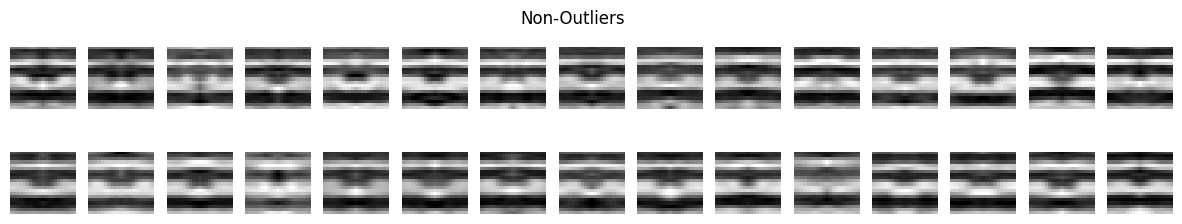

In [65]:
# Plot examples of the two clusters
cluster_0 = kmeans_vgg.labels_ == 0
cluster_1 = kmeans_vgg.labels_ == 1

num_cols = 15
num_rows = 2
plt.figure(figsize=(15, 2.5))
plt.suptitle("Outliers")
for i, avg in enumerate(all_avgs[cluster_0]):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(avg, cmap="gray")
    plt.axis("off")
    if i == num_cols * num_rows - 1:
        break
plt.show()

plt.figure(figsize=(15, 2.5))
plt.suptitle("Non-Outliers")
for i, avg in enumerate(all_avgs[cluster_1]):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(avg, cmap="gray")
    plt.axis("off")
    if i == num_cols * num_rows - 1:
        break
plt.show()